In [63]:
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import pandas as pd
from numpy.polynomial.polynomial import Polynomial


from scipy import signal
import pywt
import cwt ## change import wt into import cwt, then, in cwt, change from .mytracing import skeletor into from mytracing import skeletor


In [64]:
try:
    from numpy.lib.stride_tricks import (
        sliding_window_view,
    )  # New in version 1.20.0

    def get_trajectory_matrix(arr, window_shape, jump=1):
        return sliding_window_view(x=arr, window_shape=window_shape)[::jump]


except ImportError:

    def get_trajectory_matrix(arr, window_shape, jump=1):
        n_rows = ((arr.size - window_shape) // jump) + 1
        n = arr.strides[0]
        return np.lib.stride_tricks.as_strided(
            arr, shape=(n_rows, window_shape), strides=(jump * n, n)
        )

In [65]:
def fig_ax(figsize=(15, 4)):
    return plt.subplots(figsize=figsize)

In [66]:
def trim_wavelet(x, psi, tol=1e-2):
    l = np.argmax(np.abs(psi)>tol)
    r = len(x) - np.argmax(np.abs(psi[::-1])>tol) - 1
    x = x[l:r]
    psi = psi[l:r]
    x = x / x[-1]
    return x, psi

Below we show the Gaussian Filter as well as its 1st and 2nd derivative, which are both wavelets. The second derivative is also known as the _Mexican Hat_ and is widely used since it can filter both constants and linear trends.

Text(0.5, 1.0, 'Gaussian 2nd derivative (LoG)')

<Figure size 1152x1152 with 0 Axes>

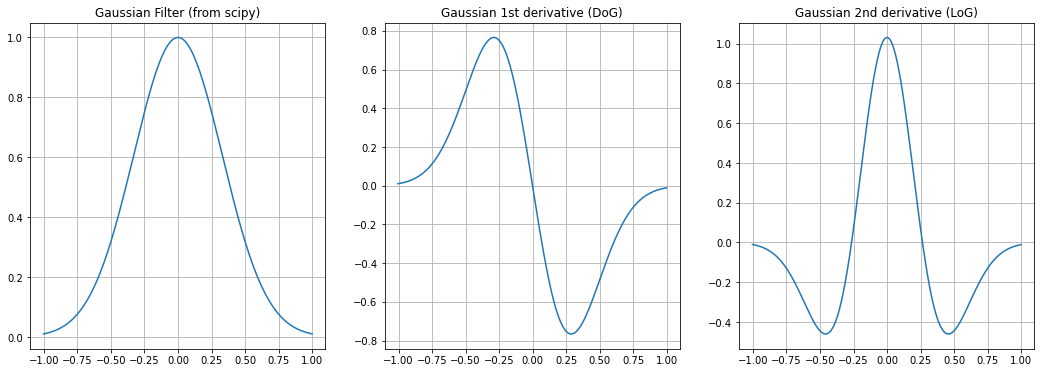

In [67]:
gaus1 = pywt.ContinuousWavelet('gaus1')
gaus2 = pywt.ContinuousWavelet('gaus2')

phi_1, x_1 = gaus1.wavefun(level=10)
phi_2, x_2 = gaus2.wavefun(level=10)
M = len(x_1)
phi_0 = signal.gaussian(M, M/10)
plt.figure(figsize=(16,16))
f, axarr = plt.subplots(1, 3, sharey=False, figsize=(18,6))
x_0, phi_0 = trim_wavelet(x_1, phi_0)
x_1, phi_1 = trim_wavelet(x_1, phi_1)
x_2, phi_2 = trim_wavelet(x_2, phi_2)
axarr[0].plot(x_0, phi_0)
axarr[0].set_title('Gaussian Filter (from scipy)')
axarr[1].plot(x_1, phi_1)
axarr[1].set_title('Gaussian 1st derivative (DoG)')
axarr[2].plot(x_2, phi_2)
axarr[2].set_title('Gaussian 2nd derivative (LoG)')

# DATA

## Test the WTMM on a Geometric Brownian Walk

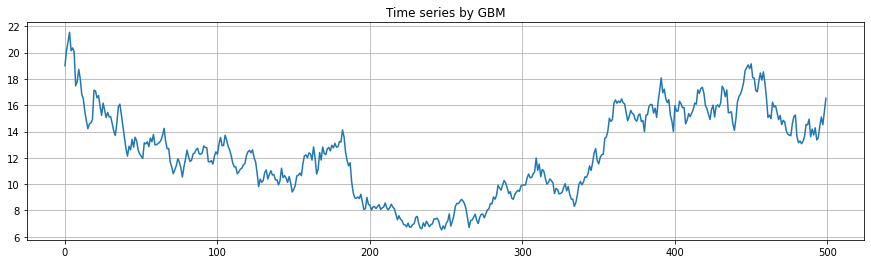

In [68]:
def gbm(T):
    """
    Geometric Brownian Motion.
    """
    ts = range(0, T)
    np.random.seed(None)
    rands = np.random.randn(T) 
    Ws = [np.sum(rands[:t]) / np.sqrt(T) for t in ts]
    sig = np.exp(Ws)
    ys = sig * (np.random.choice(100) + 1)
    fig, ax = fig_ax()
    ax.plot(ys)
    ax.set_title('Time series by GBM')
    return ys

    
ts = gbm(T=500)
scales = np.arange(1, len(ts)/2)

## Detrending with a linear fit

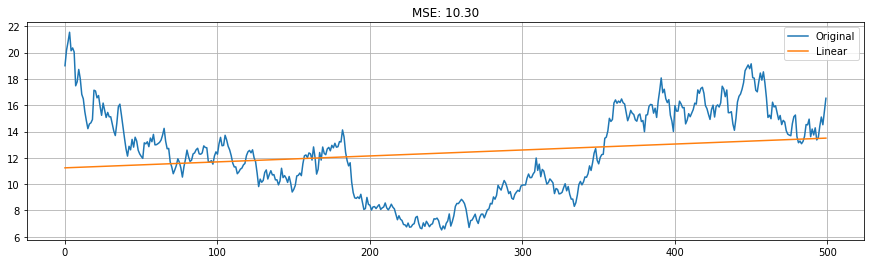

In [69]:
time_array = np.arange(ts.shape[0])
# polynomial fitting
poly_lin = Polynomial.fit(time_array, ts, deg=1)
approx_poly_lin = poly_lin(time_array)

# plot
fig, ax = fig_ax()
ax.plot(ts, label="Original")
ax.plot(approx_poly_lin, label="Linear")
ax.set_title(f"MSE: {(ts-approx_poly_lin).var():.2f}")

_ = plt.legend()

Text(0.5, 1.0, 'Detrended Geometric Brownian Walk')

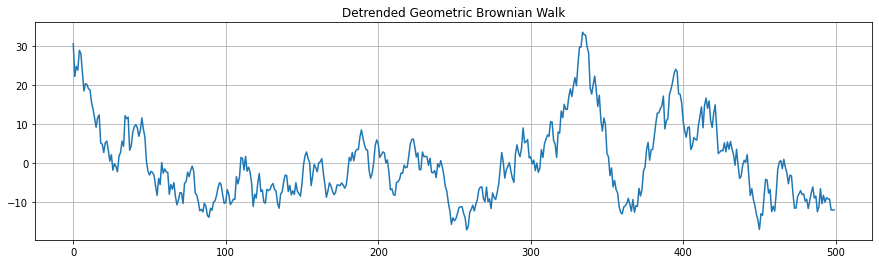

In [70]:
fig, ax = fig_ax()

sig_detrend_bw = ts-approx_poly_lin

ax.plot(sig_detrend)
ax.set_title("Detrended Geometric Brownian Walk")

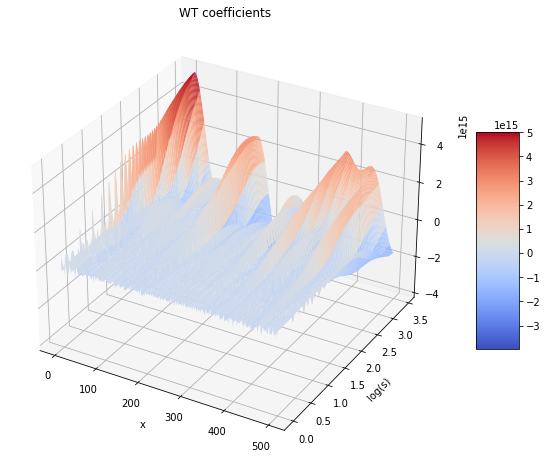

In [72]:

scales = np.linspace(1,31, 500)

# normalize the signal to fit in the wavelet
sig = cwt.normalize_signal(sig_detrend_bw)

# Run the transform
cwtmatr = signal.cwt(sig, signal.ricker, scales)

X = np.arange(np.shape(sig)[0])
Y = np.log(scales)
Z = cwtmatr
x, y = np.meshgrid(X,Y)

# show hight map in 3d
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(x, y, Z, cmap=cm.coolwarm)
plt.title('WT coefficients')
plt.xlabel("x")
plt.ylabel("log(s)")
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

In [73]:
my_data = np.genfromtxt('SPidx-1984-1990.csv', delimiter=',')
signal_1990 = my_data[1:,-1] ## taking close column only


Text(0, 0.5, 'Close Price')

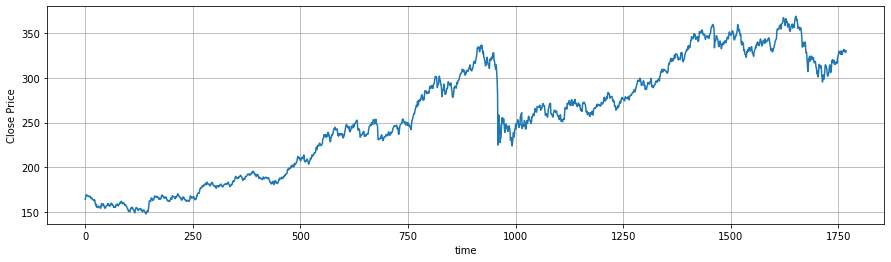

In [74]:
fig, ax = fig_ax()
ax.plot(signal_1990)
ax.set_xlabel("time")
ax.set_ylabel("Close Price")

Detrending with the constant trend

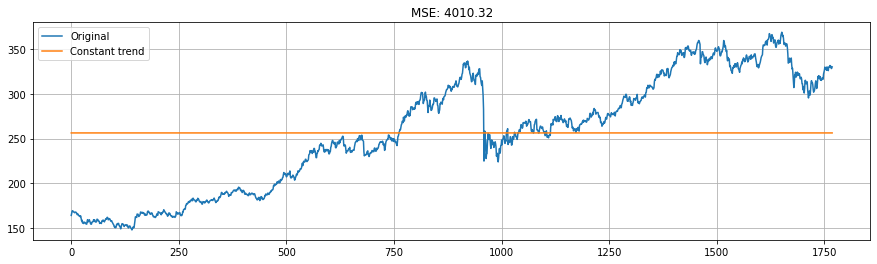

In [75]:
fig, ax = fig_ax()
ax.plot(signal_1990, label="Original")

level = signal_1990.mean()  # should be zero
approx_trend = level * np.ones(signal_1990.size)
ax.plot(approx_trend, label="Constant trend")
ax.set_title(f"MSE: {(signal_1990-approx_trend).var():.2f}")
_ = plt.legend()

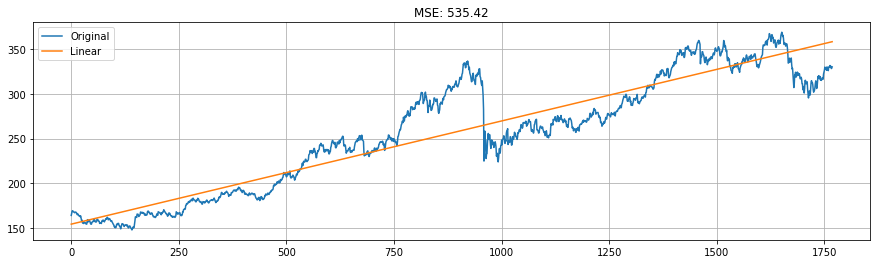

In [76]:
time_array = np.arange(signal_1990.shape[0])
# polynomial fitting
poly_lin = Polynomial.fit(time_array, signal_1990, deg=1)
approx_poly_lin = poly_lin(time_array)

# plot
fig, ax = fig_ax()
ax.plot(signal_1990, label="Original")
ax.plot(approx_poly_lin, label="Linear")
ax.set_title(f"MSE: {(signal_1990-approx_poly_lin).var():.2f}")

_ = plt.legend()

Text(0.5, 1.0, 'Detrended S&P500 index from 1984-1990')

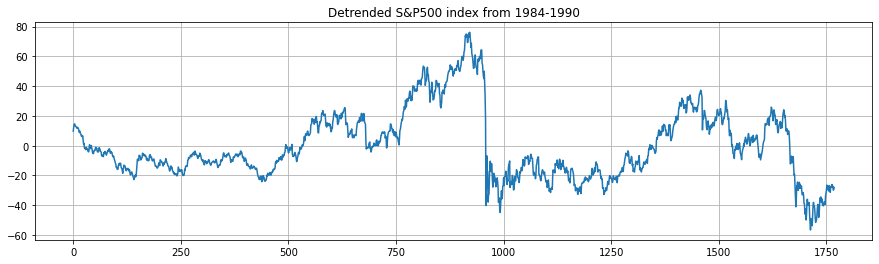

In [77]:
fig, ax = fig_ax()

sig_detrend = signal_1990-approx_poly_lin

ax.plot(sig_detrend)
ax.set_title("Detrended S&P500 index from 1984-1990")

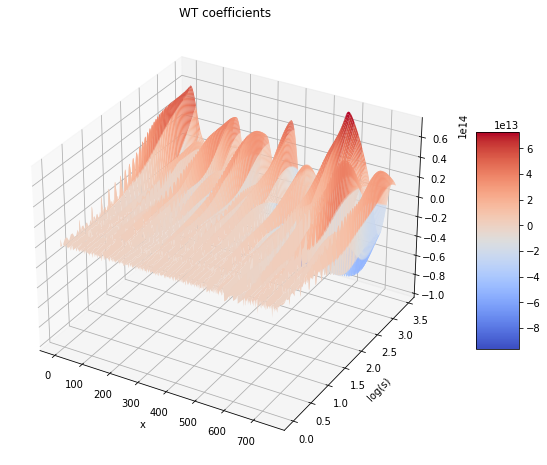

In [78]:
import matplotlib.pyplot as plt
from matplotlib import cm

scales = np.linspace(1,31, 500)

sig = sig_detrend

# normalize the signal to fit in the wavelet
sig = cwt.normalize_signal(sig)[:750]

# Run the transform
cwtmatr = signal.cwt(sig, signal.ricker, scales)

X = np.arange(np.shape(sig)[0])
Y = np.log(scales)
Z = cwtmatr
x, y = np.meshgrid(X,Y)

# show hight map in 3d
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(x, y, Z, cmap=cm.coolwarm)
plt.title('WT coefficients')
plt.xlabel("x")
plt.ylabel("log(s)")
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

## Compute  the WTMM Tree for the S&P500 index

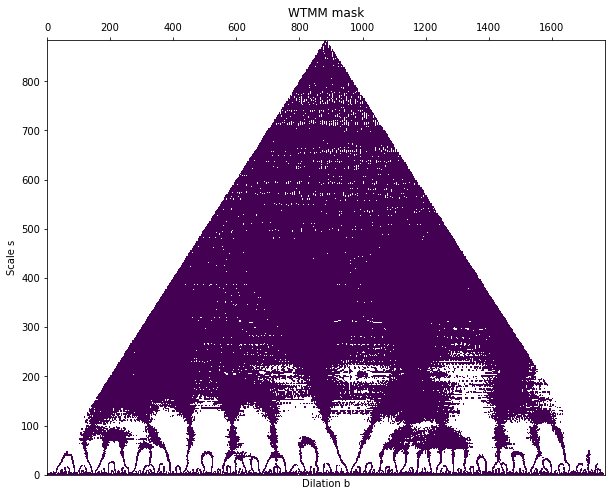

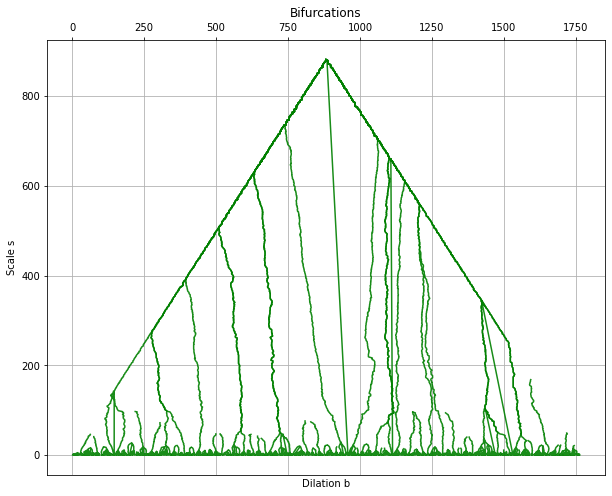

In [87]:
gaus2 = pywt.ContinuousWavelet('gaus2')

wtmm_trend, coefs_trend, ridges_trend = cwt.wtmm(sig_detrend, wavelet=gaus2, plot=True, remove_inf=True,
                                             order=1, proximity=9, scales=np.arange(1,1000)) ## change wt.cwt.wtmm into cwt.wtmm